# Trabajo practico integrado Comunicaciones digitales
Alumnos:
- Krede Julian
- Piñera, Nicolas

---
## Introduccion: 
Este trabajo práctico tiene como objetivo estudiar el funcionamiento del sistema de comunicación LoRaWAN el cual es una red de tipo LPWAN (Low Power Wide Area Network), la cual utiliza LoRa (Long Range) como su tecnología de modulación.

Una LPWAN es una red de telecomunicaciones diseñada específicamente para la comunicación de dispositivos que requieren cobertura de largo alcance y bajo consumo energético, características fundamentales en aplicaciones de Internet de las Cosas (IoT).

Con el fin de analizar en profundidad este sistema, se propone la lectura y el estudio de dos artículos científicos:
1. **"Frequency Shift Chirp Modulation: The LoRa Modulation"** – Lorenzo Vangelista
2. **"From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation"** – Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang

A partir del análisis de estos trabajos, se derivan los siguientes resultados y conclusiones sobre el sistema de modulación y funcionamiento de la capa física (PHY) en LoRaWAN.


In [19]:
# Librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt

## Codificador y Decodificador

### 1. Codificador
La codificación propuesta se realiza mediante el polinomio de numeración posicional en base 2. Para ello, se requiere la elección de un parámetro conocido como **_Spreading Factor_ ($SF$)**, el cual puede tomar los siguientes valores: $\{7,8,9,10,11,12\}$. Este parámetro representa la cantidad de dígitos binarios que conforman un símbolo.

Para generar un símbolo, se utiliza la siguiente ecuación:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde:
- $s(nT_s)$ Representa el simbolo resultante
- $\text{w}(nT_s)_h$ Es el digito binario en la posicion $h$
- $2^h$ Es el peso del digito binario, en funcion de la posicion del mismo
- $T_s$ es el período de un símbolo
- $n$ es el índice del símbolo que indica la posición temporal dentro de la secuencia.

Por ejemplo, si se tiene un $SF=8$ y se desea codificar el dato $[0\ 1\ 1\ 1\ 1\ 0\ 0\ 0]$:

$$
s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0 \times 2^7 + 1 \times 2^6 + 1 \times 2^5 + 1 \times 2^4 + 1 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 0 \times 2^0 = 120
$$

A continuacion, se realiza el generador de bits con una distribucion de probabilidad uniforme, que recibe por parametro la cantidad de bits a generar. 

Luego se realiza la funcion que se va a encargar de codificaro los bits generados en simbolos a transmitir, por medio de la ecuacion presentada en el documento. Este codificador recibe por parametro los bits generados y el SF (Spreading Factor)

In [20]:
# Generador de bits aleatorios
def generate_random_bits(total_bits):
    """
    Genera un vector de bits aleatorios (0 y 1) de longitud especificada.

    Args:
        cantidad_Bits (int): Cantidad de bits a generar.

    Returns:
        bits_transmitidos: Vector de bits aleatorios (0 y 1).
    """
    return np.random.randint(0, 2, total_bits)

In [21]:
def codificador(SF, bits_transmitidos):
    """
    Codifica un señal binaria mediante el polinomio de numeración posicional en base 2 

    Args:
        SF (int): Spreading Factor
        bits_transmitidos (array): Vector de bits a transmitir

    Returns:
        numero_de_simbolos (int): Cantidad de simbolos codificados
        simbolos (array): vector de simbolos codificados
    """
    cantidad_Bits = len(bits_transmitidos) # Cantidad de bits transmitidos
    
    # Numero de simbolos a transmitir
    numero_de_simbolos = cantidad_Bits // SF

    # Vector de ceros con la longitud de la cantidad de simbolos
    simbolos = np.zeros(numero_de_simbolos, dtype=int)

    # Sumatoria - Ecuacion 1
    ## Simbolo i
    for i in range(numero_de_simbolos):

        # de 0 hasta SF-1
        for h in range(SF):
            "Toma bits dentro de un bloque de bits de largo SF"
            "Luego se suma cada bit con su peso para obtener el valor decimal del simbolo a transmitir"

            bit = bits_transmitidos[i * SF + h]
            simbolos[i] += bit * (2**h)  # Conversion a decimal

    return numero_de_simbolos, simbolos


### 2. Decodificador

El decodificador implementa el algoritmo de divisiones sucesivas por 2 para recuperar el dato a partir del símbolo recibido. 

El procedimiento consiste en dividir el número original entre 2 de forma repetida. En cada división, se registra el residuo o módulo (que siempre será 0 o 1), y se reemplaza el número por el cociente entero obtenido. 

Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el número binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el último hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\ 
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\ 
\ldots,\ 
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]$$

In [22]:
def decodificador(simbolos_rx, SF=8):
    """Decodifica una señal binaria mediante el polinomio de numeración posicional en base 2 
    
    Args:
        SF (int, optional): Spreading factor valor entero que representa la cantidad de bits que componen un simbolo codificado puede tomar valores [7,12]. Defaults to 8.
        simbolos_rx (_type_, optional): _description_. Defaults to None.
        
    Returns:
        bits_rx (np.ndarray): Vector plano de bits decodificados.
    """
    if(SF < 7 or SF > 12):
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")
    
    bits_rx = []

    for simbolo in simbolos_rx: # Se toma cada simbolo
        bits = []
        for _ in range(SF): # Se repite la division por 2 hasta SF-1
            bits.append(simbolo % 2)
            simbolo = simbolo//2
        bits_rx.extend(bits)  # Agrega los bits en orden LSB a MSB

    return np.array(bits_rx, dtype=int)  # Asegura que sea un array plano de enteros

### 3. Bit error rate

El _Bit Error Rate_ (BER) representa la proporción de bits recibidos con error respecto al total de bits transmitidos. Se calcula de la siguiente forma:

$$BER=\frac{\text{número de bits erróneos}}{\text{total de bits transmitidos}}$$

In [23]:
def calculador_ber(bits_tx, bits_rx):
    """Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        float: Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)
    
    return ber

### 4. Ejemplo

A continuacion se realiza un ejemplo de como quedaria una codificacion, decodificaion y el calculo del **BER**

In [24]:
SF = 8                              # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 10                  # Cantidad de símbolos a transmitir             
total_bits = SF * cant_simbolos     # Total de bits a transmitir
B=125e3                             # Ancho de banda (en Hz)

In [25]:
# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)
print("---" * 10)
print("Primeros 20 bits a transmitir: ", bits_tx[0:20])
print("---" * 10)

------------------------------
Primeros 20 bits a transmitir:  [1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0]
------------------------------


In [26]:
numero_simbolos, simbolos = codificador(SF, bits_tx)
print("---" * 10)
print("Cantidad de simbolos detectados: ", numero_simbolos)
print("Primeros 10 simbolos: ", simbolos[0:numero_simbolos])
print("---" * 10)

------------------------------
Cantidad de simbolos detectados:  10
Primeros 10 simbolos:  [ 77  64 183 206  70 233 166 146 163 151]
------------------------------


In [27]:
# Decodificaion de simbolos
bits_rx = decodificador(simbolos, SF)
print("---" * 10)
print("Primeros 20 bits recibidos: ", bits_rx[0:20])
print("---" * 10)

------------------------------
Primeros 20 bits recibidos:  [1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0]
------------------------------


In [28]:
print("---" * 10)
print("Bits originales (muestra):   ", bits_tx[: 2 * SF])
print("Bits decodificados (muestra):", bits_rx[: 2 * SF])
print("La tasa de error de bit (BER) es: ", calculador_ber(bits_tx, bits_rx)*100, "%")
print("---" * 10)

------------------------------
Bits originales (muestra):    [1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0]
Bits decodificados (muestra): [1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0]
La tasa de error de bit (BER) es:  0.0 %
------------------------------


## Conformador de onda y conformador de n-tuplas

### 1. Conformador de onda

El proximo paso en nuestro sistema de comunicacion es el conformador de onda o waveform former, el cual es la etapa posterior al codificador. Nuestro conformador de onda implementa la modulación **_Frequency Shift Chirp Modulation_ (FSCM)**.

En esta modulación, cada símbolo se asocia a una frecuencia inicial determinada por su valor decimal $s(nT_s)$.  A partir de esta frecuencia, la señal modulada presenta un barrido lineal en frecuencia (tipo chirp), donde la frecuencia incrementa linealmente con el tiempo, siguiendo el índice $k=0,1,...,2^{SF}-1$, hasta alcanzar un valor máximo de $2^{SF}$. 

Luego, la frecuencia decae hasta 0 y vuelve a incrementarse, completando así una oscilación en frecuencia que regresa al valor inicial. Esta modulación al realizarse con una señal compleja, se compone de una componente real o fase (I) y otra componente imaginaria o cuadratura (Q). Esto se representa por la siguiente ecuacion: 


$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k)\cdot{\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

En la misma: 
- Toma un símbolo codificado $𝑠∈{0,1,...,2^{𝑆𝐹}−1}$
- Lo inserta como un shift de frecuencia inicial en una señal chirp.
- Genera una onda compleja cuya frecuencia aumenta linealmente en el tiempo (chirp) y comienza en una frecuencia determinada por **𝑠**.

$c(nT_s + kT)$ es una funcion que tiene dos argumentos contantes $T_s$ y $T$ son los tiempos a utilizar, donde $T_s$ es tiempo que dura un simbolo de la modulacion lora y $T$ es el tiempo de muestreo o funcionamiento del sistema. El primer argumento $kT$ nos dice donde va a existir la señal (donde se muestrea la señal), $K$ vuelve a 0 cuando termina de muestrear un simbolo o sea termina un $T_s$ se va a ir desplazando la generacion de la señal segun los nuevos simbolos.

Se conforma una señal compleja (exponencial) la cual podriamos verla como una $e^{2.pi.f.j} = cos(2.pi.f) + j.sen(2.pi.f)$ (relacion de euler - utilizarla para graficarla) su frecuencia se va a modificar segun los valores de $k$ y los simbolos, la informacion viaja en la frecuencia y la tenemos en el primer instante de muestreo $(k=0)$. El modulo que se presenta en la ecuacion cumple la funcion de limitar el ancho de banda.

Lo importante a tener en cuenta es que la chirp para diferentes simbolos son ortogonales y tienen energia = 1 debido a su amplitud.

Aplicando la ecuación de **Euler** se llega a la siguiente expresión equivalente:

$$ c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} .\quad [\cos(2 .\pi .(s(nT_s) + k)_{mod 2^{SF}} . k\frac{TB}{2^{SF}})] +\quad j .\quad [\sin(2 .\pi .(s(nT_s) + k)_{mod 2^{SF}} . k\frac{TB}{2^{SF}})] \quad con \quad k = 0, \dots, 2^{SF} - 1$$

De este modo, se muestran claramente las dos partes ortogonales de la señal: la componente en fase, asociada al **coseno** (parte real), y la componente en cuadratura, asociada al **seno** (parte imaginaria)

Analizando las ecuación se pueden observar:
- $k$ Es el indice de tiempo discreto que actua como contador haciendo que la frecuencia aumente linealmente.
- La frecuencia inicial (cuando $k=0$) viene dado por el valor del simbolo $s(nT_s)$
- El modulo de $(s(nT_s) + k)$ en base $2^{SF}$ ($(s(nT_s) + k) \bmod 2^{SF}$) tiene por fin limitar el crecimiento lineal de la frecuencia hasta un valor de frecuencia maximo $2^{SF}-1$ con el proposito de limitar el ancho de banda. Esta operacion genera un discontinuidad en la frecuencia haciendo que la misma caiga desde el valor maximo hasta $0$ para luego continuar creciendo hasta el valor inicial $s(nT_s)$ finalizando el periodo $T_s$ del simbolo.
- El factor $\frac{1}{\sqrt{2^{SF}}}$ tiene por fin normalizar la potencia de la señal
- El periodo de muestreo $\frac{TB}{2^{SF}}$

A continuacion se presenta el conformador de onda, el cual define el numero de muestras $(N_s = 2^{SF})$, la amplitud de la exponencial compleja $(\frac{1}{\sqrt{Ns}})$, el periodo de muestreo y los valores de $k$, genera la exponencial compleja y devuelve una matriz en la cual cada fila tiene los valores de la funcion chirp correspondiente a su simbolo, y en las columnas tiene los valores de esa funcion chirp en cada tiempo de muestreo

In [29]:
def conformador_de_onda(simbolos, SF, samples_per_chirp, B):
    """
    Genera la forma de onda aplicando FSCM para una secuencia de símbolos. 

    Parámetros:
    - simbolos (list): lista de símbolos codificados a ser modulados en forma de chirps.
    - SF (int): Spreading Factor
    - samples_per_chirp (int): muestras por chirp o factor de oversampling
    - B (int): Ancho de banda (Hz). 

    Retorna:
    - Array (len(simbolos), total_muestras): Simbolos modulados en forma de chirps
    """
    Ns = 2**SF                                       # Muestras por símbolo (cuando samples_per_chirp=1)
    T = 1 / B                                        # Duración de símbolo (segundos)
    delta = 1 / samples_per_chirp                    # Paso de tiempo para oversampling
    total_muestras = Ns * samples_per_chirp          # Total de muestras por símbolo

    simbolos_modulados = []
    fmax = (Ns - 1) * B / Ns                         # Frecuencia máxima para el chirp, utilizado para aplicar el modulo de manera condicional
    for s in simbolos:
        chirp = np.zeros(total_muestras, dtype=complex)
        k = s  

        for n in range(total_muestras):
            f = k * B / Ns
            t = k * T
            if f >= fmax:               # Modulo de 2**SF
                k -= Ns                 # Devuelve k a 0
                f = k * B / Ns          # Calcula f para k=0
            arg = f * t * 0.5 
            sample = (1 / np.sqrt(Ns * samples_per_chirp)) * np.exp(1j * 2 * np.pi * arg)
            chirp[n] = sample
            k += delta

        simbolos_modulados.append(chirp)

    return np.array(simbolos_modulados)


### 2. Formador de ntuplas

Para recuperar el simbolo modulado se proyecta la señal recibida $r(nT_s + kT)$ en el conjunto de bases conjugadas con las que se moduló la señal, en nuestro caso la base con la que se modulo la señal esta formada por una unica señal $c(nT_s + kT)$. Por lo tanto la proyección:

$$\langle r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q} \rangle$$

$$=\sum_{k=0}^{2^{SF}-1}r(nT_s+kT)\, \cdot \, c^*(nT_s+kT)|_{s(nT_s)=q}$$

Se llega a la siguiente expresión:

$$=\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

La cual es la transformada de Fourier discreta de la señal $d(nT_s + kT)$

In [30]:
def formador_de_ntuplas(simbolos_modulados, SF, samples_per_chirp):
    """
    Recupera los símbolos modulados en mediante FSCM y estima los símbolos transmitidos a partir de ellos.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - SF (int): Spreading Factor
    - samples_per_chirp (int): muestras por chirp o factor de oversampling

    Retorna:
    -(list (int)) Lista de símbolos estimados
    """
    Ns = 2**SF
    total_muestras = Ns * samples_per_chirp

    simbolos_estimados = []

    n = np.arange(total_muestras)
    k = n / samples_per_chirp # Ajustamos para la cantidad de samples por chirp
    
    exp_frec_decr= np.exp(-1j * np.pi * (k**2) / Ns)

    for r in simbolos_modulados:
        # Dechirp multiplicando por el conjugado del chirp base
        dechirp = r * exp_frec_decr
        
        # Calculamos la FFT
        fft_out = np.fft.fft(dechirp)
        
        # El valor máximo en la FFT nos da el símbolo estimado
        simbolo_estimado = int(np.argmax(np.abs(fft_out)))
        
        # Cuando se usa samples_per_chirp > 1 (oversampling), la FFT se calcula sobre Ns * samples_per_chirp puntos (en lugar de Ns).
        simbolo_estimado = simbolo_estimado % Ns
        
        simbolos_estimados.append(simbolo_estimado)

    return simbolos_estimados

### 3. Symbol error rate (SER)



El _Symbol Error Rate_ (SER), similar al BER, representa la proporción de simbolos recibidos con error respecto al total de simbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{número de simbolos erróneos}}{\text{total de simbolos transmitidos}}$$

Los simbolos que salen del **n-tuple former** y se comparan con los simbolos que entran al **waveform former**

In [31]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """Calcula la tasa de error de simbolos (SER) entre los simbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de simbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de simbolos recibidos.

    Returns:
        float: Tasa de error de simbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de simbolos transmitidos y recibidos deben tener la misma longitud.")
    
    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)
    
    return ser

In [32]:
def graficar_señal_modulada(simbolos_modulados, indice, SF, samples_per_chirp, B):
    """
    Grafica la señal modulada en tiempo (I y Q) de un símbolo dado por su índice
    dentro de la matriz de simbolos modulados.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - indice (int): posición del símbolo que se desea graficar
    - SF (int): Spreading Factor
    - B (int): ancho de banda (Hz)
    - samples_per_chirp (int): muestras por simbolo o factor de oversampling
    """
    Ns = 2**SF                                          # Muestras base por símbolo (sin oversampling)
    total_muestras = Ns * samples_per_chirp             # Muestras por símbolo con oversampling
    T = 1 / B                                           # Duración total del símbolo (s)
    T_muestra = T / samples_per_chirp                   # Duración de cada muestra (s)

    tiempo = np.arange(total_muestras) * T_muestra * 1e6  # en microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)
    Q = np.imag(muestra_simbolo_mod)

    plt.figure(figsize=(15, 2))
    plt.plot(tiempo, I, color='blue', linewidth=0.9)
    plt.title(f"Chirp LoRa - Fase (I) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 2))
    plt.plot(tiempo, Q, color='red', linewidth=0.9)
    plt.title(f"Chirp LoRa - Cuadratura (Q) - índice {indice} (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.tight_layout()
    plt.show()


In [33]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, samples_per_chirp, B, max_muestras=None):
    """
    Grafica la señal modulada completa solo de la parte en fase (I) concatenando los símbolos,
    y colorea cada símbolo con un color distinto.

    Parámetros:
    - simbolos_modulados(Array (len(simbolos), total_muestras)): Lista de símbolos modulados en forma de chirps.
    - SF: Spreading Factor
    - B: Ancho de banda (Hz)
    - samples_per_chirp: muestras por símbolo o factor de oversampling
    - max_muestras: cantidad de símbolos a graficar (opcional)
    """
    Ns = 2**SF
    total_muestras = Ns * samples_per_chirp
    T = 1 / B
    T_muestra = T / samples_per_chirp

    if max_muestras is None:
        max_muestras = len(simbolos_modulados)

    cmap = plt.get_cmap('tab10')

    plt.figure(figsize=(15, 3))
    for i in range(max_muestras):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = np.arange(i * total_muestras, (i + 1) * total_muestras) * T_muestra * 1e6
        plt.plot(tiempo_local, I, label=f'Símbolo {i}', color=cmap(i % 10), linewidth=0.6)

    plt.title(f'Fase (I) de todos los símbolos concatenados (SF={SF})')
    plt.xlabel('Tiempo [μs]')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4. Ejemplo
Se continua el proceso iniciado en el capitulo anterior agregando el **conformador de ondas** luedo de la codificacion de los bits, y agregando el **conformador de n-tuplas** antes del decodificador y realizando el calculo del **SER**

In [34]:
samples_per_chirp = 4
simbolos_modulados = conformador_de_onda(simbolos,SF,samples_per_chirp,B)
print("---"*10)
print("Salida del conformador de onda:",simbolos_modulados)
print("---"*10)

------------------------------
Salida del conformador de onda: [[-0.02737719-1.50682429e-02j -0.01750082-2.58898382e-02j
  -0.00373016-3.10265755e-02j ... -0.01924488+2.46210725e-02j
  -0.02829052+1.32743650e-02j -0.03123455-9.82544486e-04j]
 [ 0.03125   -6.12323400e-17j  0.02886205+1.19809977e-02j
   0.02202919+2.21647758e-02j ...  0.01215787-2.87879972e-02j
   0.02216478-2.20291900e-02j  0.0288804 -1.19367098e-02j]
 [-0.02619452+1.70414059e-02j -0.02669248-1.62503523e-02j
   0.00315843-3.10899791e-02j ...  0.02184141-2.23498427e-02j
   0.02964254+9.89354299e-03j  0.0039918 +3.09940006e-02j]
 ...
 [-0.02098622-2.31547227e-02j  0.00498798-3.08493527e-02j
   0.02723735-1.53195776e-02j ...  0.00849635+3.00728194e-02j
  -0.01807231+2.54942003e-02j -0.03119265+1.89234910e-03j]
 [ 0.02439804-1.95268590e-02j  0.02960438+1.00071477e-02j
   0.00750009+3.03366294e-02j ... -0.02701121+1.57148618e-02j
  -0.02787002-1.41359246e-02j -0.00322996-3.10826293e-02j]
 [-0.03057242-6.47223051e-03j -0.0131

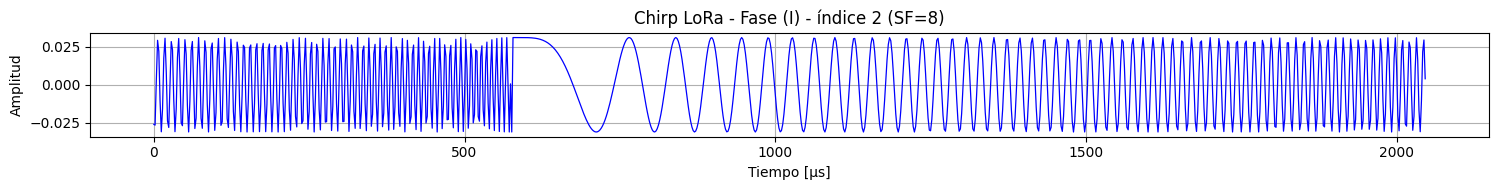

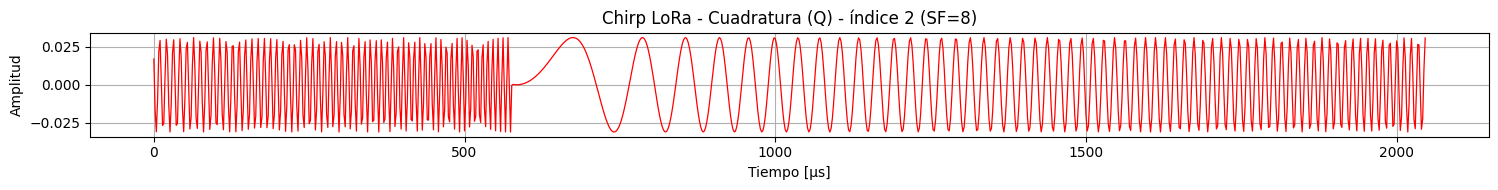

In [36]:
graficar_señal_modulada(simbolos_modulados,2,SF,samples_per_chirp,B)

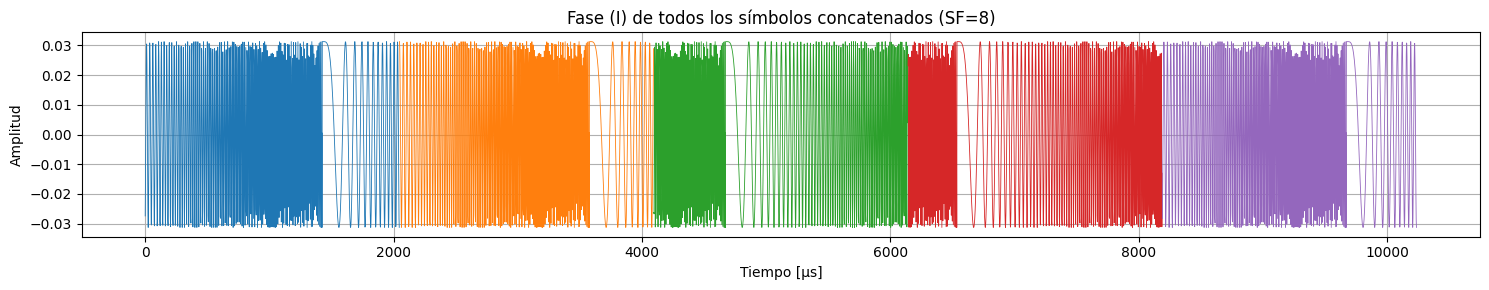

In [37]:
graficar_todas_las_senales_moduladas(simbolos_modulados,SF,samples_per_chirp,B,5)

In [38]:
simbolos_rx = formador_de_ntuplas(simbolos_modulados, SF,samples_per_chirp)
print("---"*10)
print("Salida del conformador de onda: ", simbolos_rx[0])
print("---"*10)

------------------------------
Salida del conformador de onda:  77
------------------------------


In [39]:
print("---"*10)
print("Símbolos codificados:", simbolos)
print("Símbolos recibidos:", simbolos_rx)
print("La tasa de error de simbolos (SER) es: ", calculador_ser(simbolos, simbolos_rx)*100, "%")
print("---"*10)

------------------------------
Símbolos codificados: [ 77  64 183 206  70 233 166 146 163 151]
Símbolos recibidos: [77, 64, 183, 206, 70, 233, 166, 146, 163, 151]
La tasa de error de simbolos (SER) es:  0.0 %
------------------------------
